In [18]:
import sys
import os
import json

import numpy as np
import awkward as ak
import uproot
import time
import requests

import atlasopenmagic as atom

#workdir = os.getenv('PATH_TO_W')
workdir = '/home/alangu/ppCodes/w_boson'
sys.path.append(workdir)
from utils import config as cfg
from utils.calculations import calc_mt, delta_phi
from utils import selection

In [2]:
atom.set_release(cfg.release)

data_samples = atom.build_dataset(cfg.dataset_ids, skim = cfg.skim, protocol = 'https', cache = True)

Fetching metadata for release: 2025e-13tev-beta...
Fetching datasets: 100%|███████████████████████████████████████████████████████| 374/374 [00:00<00:00, 475.53datasets/s]
✓ Successfully cached 374 datasets.
Active release: 2025e-13tev-beta. (Datasets path: REMOTE)


In [3]:
tree = uproot.open(data_samples['Data']['list'][0] + ":analysis") # Takes a while

In [19]:
sample_data = []

for data in tree.iterate(cfg.physical_variables + cfg.cut_variables + cfg.weight_variables,
                         entry_stop=tree.num_entries): 
    
    data = data[selection.trig_cuts(data.trigE, data.trigM)]

    data['leading_lep_pt'] = data['lep_pt'][:,0]
    data = data[data['leading_lep_pt'] > 7]

    data = data[selection.detector_cuts(data.lep_isTrigMatched, data.lep_isTightIso, data.lep_isTightID)]

    lep_type = data['lep_type']
    lep_eta = data['lep_eta']
    data = data[selection.type_cut(lep_type, lep_eta)]   
    
    data['m_T'] = calc.calc_mt(data['lep_e'][:, 0], data['met'], data['lep_phi'][:, 0], data['met_phi'])
    
    sample_data.append(data)
        
total_data = ak.concatenate(sample_data)

In [20]:
total_data['m_T']

<Array [137, 76.9, 33, 94, ..., 148, 254, 55.6, 64.9] type='590439 * float32'>

In [21]:
# Borrowed from Weaver

with uproot.recreate(os.path.join(workdir, 'outputs/demo_cuts.root'), compression=uproot.LZ4(4)) as fout:
    tree = fout.mktree('Data', {f: total_data[f].type for f in total_data.fields})
    start = 0
    while start < len(total_data[total_data.fields[0]]) - 1:
        tree.extend({k: total_data[k][start:start + 1048576] for k in total_data.fields})
        start += 1048576

In [22]:
cuts = uproot.open(os.path.join(workdir, 'outputs/demo_cuts.root') + ':Data')

In [23]:
cuts.show()

name                 | typename                 | interpretation                
---------------------+--------------------------+-------------------------------
nlep_e               | int32_t                  | AsDtype('>i4')
lep_e                | float[]                  | AsJagged(AsDtype('>f4'))
nlep_pt              | int32_t                  | AsDtype('>i4')
lep_pt               | float[]                  | AsJagged(AsDtype('>f4'))
nlep_phi             | int32_t                  | AsDtype('>i4')
lep_phi              | float[]                  | AsJagged(AsDtype('>f4'))
nlep_eta             | int32_t                  | AsDtype('>i4')
lep_eta              | float[]                  | AsJagged(AsDtype('>f4'))
met                  | float                    | AsDtype('>f4')
met_phi              | float                    | AsDtype('>f4')
nlep_type            | int32_t                  | AsDtype('>i4')
lep_type             | int32_t[]                | AsJagged(AsDtype('>i4'))
nlep_isT

In [25]:
cuts['m_T'].array()

<Array [137, 76.9, 33, 94, ..., 148, 254, 55.6, 64.9] type='590439 * float32'>

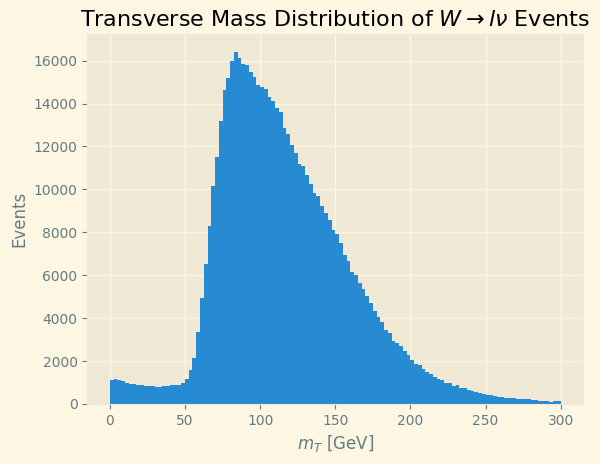

In [96]:
import matplotlib.pyplot as plt

plt.style.use('Solarize_Light2')

transverse_mass = total_data['m_T'].to_numpy()

mt_end = 300 * cfg.GeV
bin_width = 2.5 * cfg.GeV
num_bins = int(mt_end / bin_width)

fig, axes = plt.subplots()

axes.hist(transverse_mass, bins = num_bins, range = [0, 300])
axes.set_ylabel(r'Events')
axes.set_xlabel(r'$m_T$ [GeV]')
axes.set_title(r'Transverse Mass Distribution of $W \rightarrow l\nu$ Events')
plt.show()